#Pre Working

Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('./drive', force_remount=True)

#!unzip -uq "/drive/My Drive/A05_P02_Dataset.zip" -d "/drive/My Drive/Assignment5P2"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at ./drive


Import Libraries

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import time
import os
import copy
import csv
from tqdm import tqdm
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report
from sklearn.metrics import multilabel_confusion_matrix

Import Datasets

In [0]:
COVID_DataSet = './drive/My Drive/Assignment5P2/A05_P02_Dataset'

In [10]:
#Define transforms for the training data and testing data
# 256

GLOBAL_BATCH_SIZE = 20

train_transforms = transforms.Compose([transforms.Resize(224),
                                       transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])


test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])


#pass transform here-in
train_data = datasets.ImageFolder(COVID_DataSet + '/Train', transform = train_transforms)
test_data = datasets.ImageFolder(COVID_DataSet + '/Test', transform = test_transforms)
valid_data = datasets.ImageFolder(COVID_DataSet + '/Validation', transform = valid_transforms)

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size = GLOBAL_BATCH_SIZE, shuffle = True)
testloader = torch.utils.data.DataLoader(test_data, batch_size = GLOBAL_BATCH_SIZE, shuffle = True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size = GLOBAL_BATCH_SIZE, shuffle = True)

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['covid-19', 'normal', 'pneumonia']


In [11]:
print(len(train_data))
print(len(test_data))
print(len(valid_data))

6200
629
628


###Custom Functions

In [0]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

def plot_curve(epochLst, errorLst):
    plt.plot(epochLst, errorLst, color='blue', label='Learning Line')
    plt.legend()
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.show()

In [0]:
# working
def oneHotEncodingLabel(input):
  enc = torch.zeros([len(input), 3], dtype=torch.float32, device="cuda:0")

  for i in range(len(enc)):
    if input[i] == 0:
      enc[i][input[i]] = 1
      enc[i][input[2]] = 1
    if input[i] == 1:
      enc[i][input[i]] = 1  
    if input[i] == 2:
      enc[i][input[i]] = 1

  return enc

In [0]:
def hotEncodingPrediction(input):
  for row in range(len(input)):
    if input[row][0].item() > input[row][1].item() and input[row][0].item() > input[row][2].item():
      input[row][0] = 1.0
      input[row][1] = 0.0
      input[row][2] = 0.0
    if input[row][1].item() > (input[row][0].item() and input[row][1].item() > input[row][2].item()):
      input[row][1] = 1.0
      input[row][0] = 0.0
      input[row][2] = 0.0
    if input[row][2].item() > (input[row][0].item() and input[row][2].item() > input[row][1].item()):
      input[row][2] = 1.0
      input[row][0] = 0.0
      input[row][1] = 0.0
  return input

In [0]:
def hotEncodingPrediction50(input):
  for row in range(len(input)):
      for col in range(len(input[row])):
          if input[row][col].item() >=0.5:
              input[row][col] = 1
          else:
              input[row][col] = 0
  return input

In [0]:
def oneHotEncoding1(input):
  enc = torch.zeros([len(input), 3], dtype=torch.float32, device="cuda:0")

  _, predicted = torch.max(input.data, 1)
  for i in range(len(predicted)):
    if predicted[i] == 0:
      enc[i][predicted[i]] = 1
    elif predicted[i] == 1:
      enc[i][predicted[i]] = 1
    elif predicted[i] == 2:
      enc[i][predicted[i]] = 1

  # print('print predicted')
  # print(predicted)
  return enc

In [0]:
# Copied

def CalculateF1(y_true,y_pred):
  tp = (y_true * y_pred).sum()
  tn = ((1 - y_true) * (1 - y_pred)).sum()
  fp = ((1 - y_true) * y_pred).sum()
  fn = (y_true * (1 - y_pred)).sum()
  epsilon = 1e-7

  precision = tp / (tp + fp + epsilon)
  recall = tp / (tp + fn + epsilon)
  f1 = 2* (precision*recall) / (precision + recall + epsilon)

  print("\n precision = ",precision, "\n Recall    = ", recall, "\n F1 score = ", f1)

Image Show

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


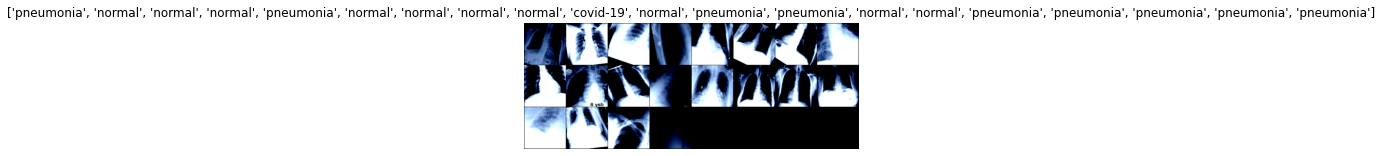

In [17]:
# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)

#Task 1: Load pretrained CNN model and fine-tune FC Layers

FOCAL LOSS 

In [0]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        #BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduce=False)
        BCE_loss = nn.BCEWithLogitsLoss(inputs, targets)
        pt = torch.exp(-BCE_loss)
        loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        return loss

###ResNet-18

In [19]:
# Load the pretrained model from pytorch [Pretrained on ImageNet]
T1_ResNet18_Model = models.resnet18(pretrained=True)
#print(T1ResNet18)
print('Output Layer of RESNET-18 : ', T1_ResNet18_Model.fc.out_features)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth



Output Layer of RESNET-18 :  1000


In [0]:
# Remove last layer FC Layer

# T1_ResNet18_Modules = list(T1_ResNet18_Model.children())[:-1]      # delete the last fc layer.
# T1_ResNet18_Feature = nn.Sequential(*T1_ResNet18_Modules)

#print(T1_ResNet18_Feature)

In [0]:
# Freeze training for all layers
# for param in T1_ResNet18_Model.parameters():
#     param.require_grad = True

In [0]:
# Adding New Layer (FC - Layer)

# Input:25088                     Output:(Last 2 Digits * 10)+100
# Input:(Last 2 Digits * 10)+100  Output:Len(Class) = 2

# T1_ResNet18_Modules.extend([nn.Linear(25088, (40 * 10) + 100)])
# T1_ResNet18_Modules.extend([nn.Linear((40 * 10) + 100, len(class_names))])

# print(len(class_names))

In [0]:
# Update CNN after adding 2 FC Layers

#T1_ResNet18_Model.fc = nn.Sequential(*T1_ResNet18_Feature)

OutnInLayer = ((40 * 10) + 100)

T1_ResNet18_Model.fc = nn.Sequential( nn.Linear(512, OutnInLayer),
                                      nn.ReLU(inplace=True),
                                      nn.Linear(OutnInLayer, 3))

#print(T1_ResNet18_Model)

In [24]:
print(T1_ResNet18_Model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
# Loss Function and Optimizer

T1_ResNet18_Epochs = 10
T1_ResNet18_LearningRate = 0.0001
T1_ResNet18_Momentum = 0.9
T1_ResNet18_Criterion = nn.BCEWithLogitsLoss()
T1_ResNet18_BCE_alpha = 1
T1_ResNet18_BCE_gamma = 2

T1_ResNet18_Optimizer = optim.SGD(T1_ResNet18_Model.parameters(), lr = T1_ResNet18_LearningRate, momentum = T1_ResNet18_Momentum)

Training




0it [00:00, ?it/s]


Train Epoch: 0 [0/6200 (0%)]	Loss: 0.142252: : 0it [00:00, ?it/s]


Train Epoch: 0 [0/6200 (0%)]	Loss: 0.142252: : 1it [00:00,  1.74it/s]


Train Epoch: 0 [20/6200 (0%)]	Loss: 0.077637: : 1it [00:01,  1.74it/s]


Train Epoch: 0 [20/6200 (0%)]	Loss: 0.077637: : 2it [00:01,  1.88it/s]


Train Epoch: 0 [40/6200 (1%)]	Loss: 0.077165: : 2it [00:01,  1.88it/s]


Train Epoch: 0 [40/6200 (1%)]	Loss: 0.077165: : 3it [00:01,  1.99it/s]


Train Epoch: 0 [60/6200 (1%)]	Loss: 0.093708: : 3it [00:01,  1.99it/s]


Train Epoch: 0 [60/6200 (1%)]	Loss: 0.093708: : 4it [00:01,  2.08it/s]


Train Epoch: 0 [80/6200 (1%)]	Loss: 0.113628: : 4it [00:02,  2.08it/s]


Train Epoch: 0 [80/6200 (1%)]	Loss: 0.113628: : 5it [00:02,  2.14it/s]


Train Epoch: 0 [100/6200 (2%)]	Loss: 0.114179: : 5it [00:03,  2.14it/s]


Train Epoch: 0 [100/6200 (2%)]	Loss: 0.114179: : 6it [00:03,  1.83it/s]


Train Epoch: 0 [120/6200 (2%)]	Loss: 0.124301: : 6it [00:03,  1.83it/s]


Train Epoch: 0 [120/6200 (2%)]

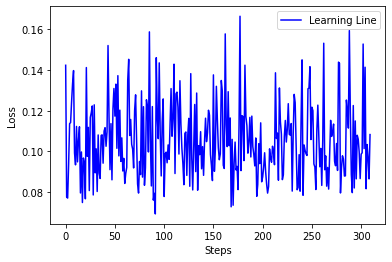




0it [00:00, ?it/s]


Train Epoch: 1 [0/6200 (0%)]	Loss: 0.104850: : 0it [00:00, ?it/s]


Train Epoch: 1 [0/6200 (0%)]	Loss: 0.104850: : 1it [00:00,  2.35it/s]


Train Epoch: 1 [20/6200 (0%)]	Loss: 0.124361: : 1it [00:00,  2.35it/s]


Train Epoch: 1 [20/6200 (0%)]	Loss: 0.124361: : 2it [00:00,  2.28it/s]


Train Epoch: 1 [40/6200 (1%)]	Loss: 0.080495: : 2it [00:01,  2.28it/s]


Train Epoch: 1 [40/6200 (1%)]	Loss: 0.080495: : 3it [00:01,  2.30it/s]


Train Epoch: 1 [60/6200 (1%)]	Loss: 0.103604: : 3it [00:01,  2.30it/s]


Train Epoch: 1 [60/6200 (1%)]	Loss: 0.103604: : 4it [00:01,  2.32it/s]


Train Epoch: 1 [80/6200 (1%)]	Loss: 0.120273: : 4it [00:02,  2.32it/s]


Train Epoch: 1 [80/6200 (1%)]	Loss: 0.120273: : 5it [00:02,  2.35it/s]


Train Epoch: 1 [100/6200 (2%)]	Loss: 0.114791: : 5it [00:02,  2.35it/s]


Train Epoch: 1 [100/6200 (2%)]	Loss: 0.114791: : 6it [00:02,  2.35it/s]


Train Epoch: 1 [120/6200 (2%)]	Loss: 0.093062: : 6it [00:03,  2.35it/s]


Train Epoch: 1 [120/6200 (2%)]

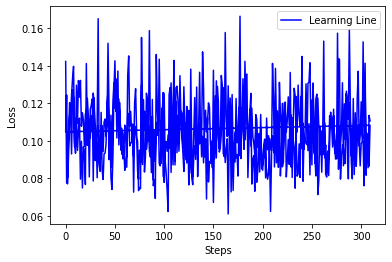




0it [00:00, ?it/s]


Train Epoch: 2 [0/6200 (0%)]	Loss: 0.132287: : 0it [00:00, ?it/s]


Train Epoch: 2 [0/6200 (0%)]	Loss: 0.132287: : 1it [00:00,  1.99it/s]


Train Epoch: 2 [20/6200 (0%)]	Loss: 0.106682: : 1it [00:00,  1.99it/s]


Train Epoch: 2 [20/6200 (0%)]	Loss: 0.106682: : 2it [00:00,  2.07it/s]


Train Epoch: 2 [40/6200 (1%)]	Loss: 0.109217: : 2it [00:01,  2.07it/s]


Train Epoch: 2 [40/6200 (1%)]	Loss: 0.109217: : 3it [00:01,  2.14it/s]


Train Epoch: 2 [60/6200 (1%)]	Loss: 0.129668: : 3it [00:01,  2.14it/s]


Train Epoch: 2 [60/6200 (1%)]	Loss: 0.129668: : 4it [00:01,  2.05it/s]


Train Epoch: 2 [80/6200 (1%)]	Loss: 0.088706: : 4it [00:02,  2.05it/s]


Train Epoch: 2 [80/6200 (1%)]	Loss: 0.088706: : 5it [00:02,  2.14it/s]


Train Epoch: 2 [100/6200 (2%)]	Loss: 0.068741: : 5it [00:02,  2.14it/s]


Train Epoch: 2 [100/6200 (2%)]	Loss: 0.068741: : 6it [00:02,  2.03it/s]


Train Epoch: 2 [120/6200 (2%)]	Loss: 0.074751: : 6it [00:03,  2.03it/s]


Train Epoch: 2 [120/6200 (2%)]

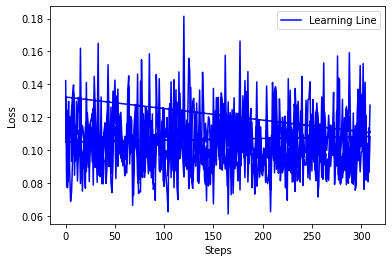




0it [00:00, ?it/s]


Train Epoch: 3 [0/6200 (0%)]	Loss: 0.105567: : 0it [00:00, ?it/s]


Train Epoch: 3 [0/6200 (0%)]	Loss: 0.105567: : 1it [00:00,  2.22it/s]


Train Epoch: 3 [20/6200 (0%)]	Loss: 0.143034: : 1it [00:00,  2.22it/s]


Train Epoch: 3 [20/6200 (0%)]	Loss: 0.143034: : 2it [00:00,  2.16it/s]


Train Epoch: 3 [40/6200 (1%)]	Loss: 0.113703: : 2it [00:01,  2.16it/s]


Train Epoch: 3 [40/6200 (1%)]	Loss: 0.113703: : 3it [00:01,  2.16it/s]


Train Epoch: 3 [60/6200 (1%)]	Loss: 0.079897: : 3it [00:01,  2.16it/s]


Train Epoch: 3 [60/6200 (1%)]	Loss: 0.079897: : 4it [00:01,  2.19it/s]


Train Epoch: 3 [80/6200 (1%)]	Loss: 0.092913: : 4it [00:02,  2.19it/s]


Train Epoch: 3 [80/6200 (1%)]	Loss: 0.092913: : 5it [00:02,  2.20it/s]


Train Epoch: 3 [100/6200 (2%)]	Loss: 0.092458: : 5it [00:02,  2.20it/s]


Train Epoch: 3 [100/6200 (2%)]	Loss: 0.092458: : 6it [00:02,  2.24it/s]


Train Epoch: 3 [120/6200 (2%)]	Loss: 0.118698: : 6it [00:03,  2.24it/s]


Train Epoch: 3 [120/6200 (2%)]

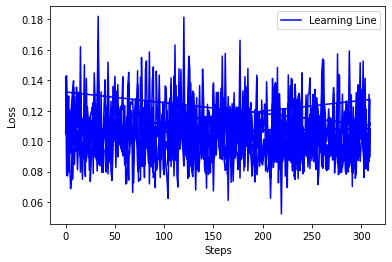




0it [00:00, ?it/s]


Train Epoch: 4 [0/6200 (0%)]	Loss: 0.098267: : 0it [00:00, ?it/s]


Train Epoch: 4 [0/6200 (0%)]	Loss: 0.098267: : 1it [00:00,  2.36it/s]


Train Epoch: 4 [20/6200 (0%)]	Loss: 0.100360: : 1it [00:00,  2.36it/s]


Train Epoch: 4 [20/6200 (0%)]	Loss: 0.100360: : 2it [00:00,  2.33it/s]


Train Epoch: 4 [40/6200 (1%)]	Loss: 0.110795: : 2it [00:01,  2.33it/s]


Train Epoch: 4 [40/6200 (1%)]	Loss: 0.110795: : 3it [00:01,  2.32it/s]


Train Epoch: 4 [60/6200 (1%)]	Loss: 0.112224: : 3it [00:01,  2.32it/s]


Train Epoch: 4 [60/6200 (1%)]	Loss: 0.112224: : 4it [00:01,  2.24it/s]


Train Epoch: 4 [80/6200 (1%)]	Loss: 0.087721: : 4it [00:02,  2.24it/s]


Train Epoch: 4 [80/6200 (1%)]	Loss: 0.087721: : 5it [00:02,  2.25it/s]


Train Epoch: 4 [100/6200 (2%)]	Loss: 0.087882: : 5it [00:02,  2.25it/s]


Train Epoch: 4 [100/6200 (2%)]	Loss: 0.087882: : 6it [00:02,  2.28it/s]


Train Epoch: 4 [120/6200 (2%)]	Loss: 0.106630: : 6it [00:03,  2.28it/s]


Train Epoch: 4 [120/6200 (2%)]

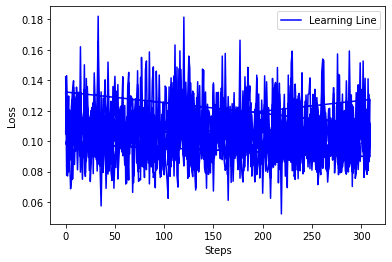




0it [00:00, ?it/s]


Train Epoch: 5 [0/6200 (0%)]	Loss: 0.108395: : 0it [00:00, ?it/s]


Train Epoch: 5 [0/6200 (0%)]	Loss: 0.108395: : 1it [00:00,  2.35it/s]


Train Epoch: 5 [20/6200 (0%)]	Loss: 0.079904: : 1it [00:00,  2.35it/s]


Train Epoch: 5 [20/6200 (0%)]	Loss: 0.079904: : 2it [00:00,  2.31it/s]


Train Epoch: 5 [40/6200 (1%)]	Loss: 0.090018: : 2it [00:01,  2.31it/s]


Train Epoch: 5 [40/6200 (1%)]	Loss: 0.090018: : 3it [00:01,  2.29it/s]


Train Epoch: 5 [60/6200 (1%)]	Loss: 0.091299: : 3it [00:01,  2.29it/s]


Train Epoch: 5 [60/6200 (1%)]	Loss: 0.091299: : 4it [00:01,  2.30it/s]


Train Epoch: 5 [80/6200 (1%)]	Loss: 0.135967: : 4it [00:02,  2.30it/s]


Train Epoch: 5 [80/6200 (1%)]	Loss: 0.135967: : 5it [00:02,  2.20it/s]


Train Epoch: 5 [100/6200 (2%)]	Loss: 0.141855: : 5it [00:02,  2.20it/s]


Train Epoch: 5 [100/6200 (2%)]	Loss: 0.141855: : 6it [00:02,  2.23it/s]


Train Epoch: 5 [120/6200 (2%)]	Loss: 0.098020: : 6it [00:03,  2.23it/s]


Train Epoch: 5 [120/6200 (2%)]

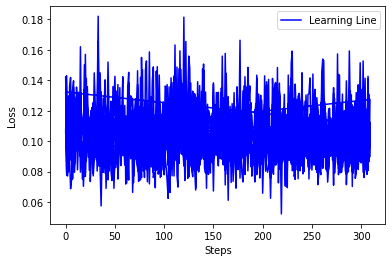




0it [00:00, ?it/s]


Train Epoch: 6 [0/6200 (0%)]	Loss: 0.099841: : 0it [00:00, ?it/s]


Train Epoch: 6 [0/6200 (0%)]	Loss: 0.099841: : 1it [00:00,  2.34it/s]


Train Epoch: 6 [20/6200 (0%)]	Loss: 0.086757: : 1it [00:00,  2.34it/s]


Train Epoch: 6 [20/6200 (0%)]	Loss: 0.086757: : 2it [00:00,  2.32it/s]


Train Epoch: 6 [40/6200 (1%)]	Loss: 0.108977: : 2it [00:01,  2.32it/s]


Train Epoch: 6 [40/6200 (1%)]	Loss: 0.108977: : 3it [00:01,  2.27it/s]


Train Epoch: 6 [60/6200 (1%)]	Loss: 0.088652: : 3it [00:01,  2.27it/s]


Train Epoch: 6 [60/6200 (1%)]	Loss: 0.088652: : 4it [00:01,  2.26it/s]


Train Epoch: 6 [80/6200 (1%)]	Loss: 0.099328: : 4it [00:02,  2.26it/s]


Train Epoch: 6 [80/6200 (1%)]	Loss: 0.099328: : 5it [00:02,  2.28it/s]


Train Epoch: 6 [100/6200 (2%)]	Loss: 0.087647: : 5it [00:02,  2.28it/s]


Train Epoch: 6 [100/6200 (2%)]	Loss: 0.087647: : 6it [00:02,  2.27it/s]


Train Epoch: 6 [120/6200 (2%)]	Loss: 0.104527: : 6it [00:03,  2.27it/s]


Train Epoch: 6 [120/6200 (2%)]

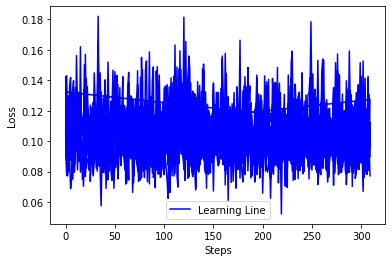




0it [00:00, ?it/s]


Train Epoch: 7 [0/6200 (0%)]	Loss: 0.077422: : 0it [00:00, ?it/s]


Train Epoch: 7 [0/6200 (0%)]	Loss: 0.077422: : 1it [00:00,  2.19it/s]


Train Epoch: 7 [20/6200 (0%)]	Loss: 0.103048: : 1it [00:00,  2.19it/s]


Train Epoch: 7 [20/6200 (0%)]	Loss: 0.103048: : 2it [00:00,  2.24it/s]


Train Epoch: 7 [40/6200 (1%)]	Loss: 0.088836: : 2it [00:01,  2.24it/s]


Train Epoch: 7 [40/6200 (1%)]	Loss: 0.088836: : 3it [00:01,  2.23it/s]


Train Epoch: 7 [60/6200 (1%)]	Loss: 0.079466: : 3it [00:01,  2.23it/s]


Train Epoch: 7 [60/6200 (1%)]	Loss: 0.079466: : 4it [00:01,  2.24it/s]


Train Epoch: 7 [80/6200 (1%)]	Loss: 0.128021: : 4it [00:02,  2.24it/s]


Train Epoch: 7 [80/6200 (1%)]	Loss: 0.128021: : 5it [00:02,  2.24it/s]


Train Epoch: 7 [100/6200 (2%)]	Loss: 0.111269: : 5it [00:02,  2.24it/s]


Train Epoch: 7 [100/6200 (2%)]	Loss: 0.111269: : 6it [00:02,  2.18it/s]


Train Epoch: 7 [120/6200 (2%)]	Loss: 0.103537: : 6it [00:03,  2.18it/s]


Train Epoch: 7 [120/6200 (2%)]

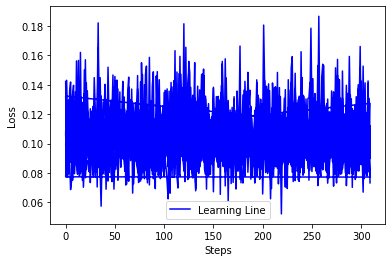




0it [00:00, ?it/s]


Train Epoch: 8 [0/6200 (0%)]	Loss: 0.114472: : 0it [00:00, ?it/s]


Train Epoch: 8 [0/6200 (0%)]	Loss: 0.114472: : 1it [00:00,  2.37it/s]


Train Epoch: 8 [20/6200 (0%)]	Loss: 0.136633: : 1it [00:00,  2.37it/s]


Train Epoch: 8 [20/6200 (0%)]	Loss: 0.136633: : 2it [00:00,  2.34it/s]


Train Epoch: 8 [40/6200 (1%)]	Loss: 0.151654: : 2it [00:01,  2.34it/s]


Train Epoch: 8 [40/6200 (1%)]	Loss: 0.151654: : 3it [00:01,  2.35it/s]


Train Epoch: 8 [60/6200 (1%)]	Loss: 0.136269: : 3it [00:01,  2.35it/s]


Train Epoch: 8 [60/6200 (1%)]	Loss: 0.136269: : 4it [00:01,  2.11it/s]


Train Epoch: 8 [80/6200 (1%)]	Loss: 0.099315: : 4it [00:02,  2.11it/s]


Train Epoch: 8 [80/6200 (1%)]	Loss: 0.099315: : 5it [00:02,  2.18it/s]


Train Epoch: 8 [100/6200 (2%)]	Loss: 0.087165: : 5it [00:02,  2.18it/s]


Train Epoch: 8 [100/6200 (2%)]	Loss: 0.087165: : 6it [00:02,  2.21it/s]


Train Epoch: 8 [120/6200 (2%)]	Loss: 0.103667: : 6it [00:03,  2.21it/s]


Train Epoch: 8 [120/6200 (2%)]

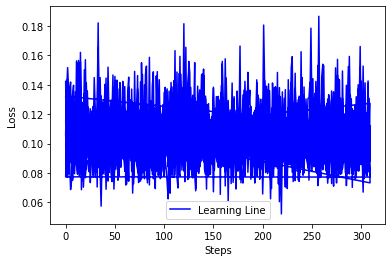




0it [00:00, ?it/s]


Train Epoch: 9 [0/6200 (0%)]	Loss: 0.094411: : 0it [00:00, ?it/s]


Train Epoch: 9 [0/6200 (0%)]	Loss: 0.094411: : 1it [00:00,  2.19it/s]


Train Epoch: 9 [20/6200 (0%)]	Loss: 0.078700: : 1it [00:00,  2.19it/s]


Train Epoch: 9 [20/6200 (0%)]	Loss: 0.078700: : 2it [00:00,  2.24it/s]


Train Epoch: 9 [40/6200 (1%)]	Loss: 0.112791: : 2it [00:01,  2.24it/s]


Train Epoch: 9 [40/6200 (1%)]	Loss: 0.112791: : 3it [00:01,  2.20it/s]


Train Epoch: 9 [60/6200 (1%)]	Loss: 0.089370: : 3it [00:01,  2.20it/s]


Train Epoch: 9 [60/6200 (1%)]	Loss: 0.089370: : 4it [00:01,  2.25it/s]


Train Epoch: 9 [80/6200 (1%)]	Loss: 0.087145: : 4it [00:02,  2.25it/s]


Train Epoch: 9 [80/6200 (1%)]	Loss: 0.087145: : 5it [00:02,  2.25it/s]


Train Epoch: 9 [100/6200 (2%)]	Loss: 0.081904: : 5it [00:02,  2.25it/s]


Train Epoch: 9 [100/6200 (2%)]	Loss: 0.081904: : 6it [00:02,  2.27it/s]


Train Epoch: 9 [120/6200 (2%)]	Loss: 0.123838: : 6it [00:03,  2.27it/s]


Train Epoch: 9 [120/6200 (2%)]

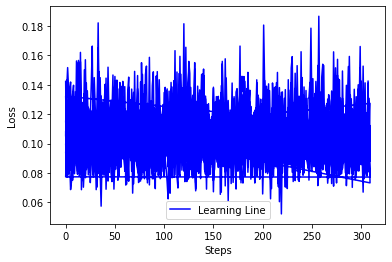

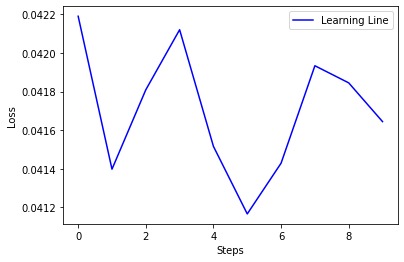

Finished Training


In [50]:
#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
T1_ResNet18_Model.to(device)

T1_ResNet18_Model.train()

T1_ResNet18_1EpochLossLst = list()
T1_ResNet18_1EpochLst = list()
T1_ResNet18_EpochLst = list()
T1_ResNet18_EpochLossLst = list()
T1_ResNet18_EpochAccuracyLst = list()

T1_ResNet18_EpochEncLabel = list()
T1_ResNet18_EpochEncPred = list()
T1_ResNet18_TotalAccuracyList = list()

for epoch in range(T1_ResNet18_Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        T1_ResNet18_Optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
       
        outputs = T1_ResNet18_Model(inputs)                           #----> forward pass
        
        encOutput = hotEncodingPrediction(outputs)
        encSigmoidOutput = hotEncodingPrediction(torch.sigmoid(outputs))
        encLabel = oneHotEncodingLabel(labels)  

        # Focal Loss Implimentation
        BCE_loss = T1_ResNet18_Criterion(encOutput.to(device), encLabel.to(device))               #----> compute loss
        pt = torch.exp(-BCE_loss)
        loss = T1_ResNet18_BCE_alpha * (1-pt)**T1_ResNet18_BCE_gamma * BCE_loss
        loss = torch.mean(loss)

        # Backword Pass and Weight Update 
        loss.backward()                                               #----> backward pass
        T1_ResNet18_Optimizer.step()                                  #----> weights update
        running_loss += loss.item() * images.size(0)                  # https://discuss.pytorch.org/t/plotting-loss-curve/42632/11
        
        
        # print statistics
        pbar.set_description('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader), loss.item()))
        
        T1_ResNet18_1EpochLossLst.append(loss.item())
        T1_ResNet18_1EpochLst.append(i)
        # Handle Accuracy
        T1_ResNet18_EpochEncLabel.extend(encLabel.cpu().numpy())
        T1_ResNet18_EpochEncPred.extend(encOutput.cpu().detach().numpy())
        
    plot_curve(T1_ResNet18_1EpochLst,T1_ResNet18_1EpochLossLst)
    T1_ResNet18_EpochLst.append(epoch)
    T1_ResNet18_EpochLossLst.append(running_loss/len(trainloader.dataset))
    # Builtin function calling
    #T1_ResNet18_TotalAccuracyList = accuracy_score(T1_ResNet18_EpochEncLabel, T1_ResNet18_EpochEncPred) 
    torch.save(T1_ResNet18_Model.state_dict(), 'res18_focal_loss.pth')

plot_curve(T1_ResNet18_EpochLst,T1_ResNet18_EpochLossLst)
#plot_curve(T1_ResNet18_TotalAccuracyList,T1_ResNet18_EpochLossLst)
print('Finished Training')

Testing

In [0]:
# dataiter = iter(testloader)
# images, labels = dataiter.next()
# show_databatch(images, labels)

Prediction

In [0]:
# images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
# outputs = T1_ResNet18_Model(images)                               #--> forward pass
# _, predicted = torch.max(outputs, 1)

# print('Predicted: \t', ' '.join('%5s' % class_names[predicted[j]]
#                               for j in range(len(images))))
# print('Ground Truth: \t', ' '.join('%5s' % class_names[labels[j]]
#                               for j in range(len(images)))) 

In [57]:
i = 0

all_out_pred_list = list()
all_out_label_list = list()

with open('COVIDTestPredictionRESNET.csv', 'w', newline='') as file:
  writer = csv.writer(file)
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          outputs = T1_ResNet18_Model(images)
          _, predicted = torch.max(outputs.data, 1)
          # sigOutput = torch.sigmoid(outputs).to(device)
          # #encSigmoidOutput = hotEncodingPrediction(sigOutput)
          # encSigmoidOutput = hotEncodingPrediction50(sigOutput)
          # print(encSigmoidOutput)

          # CSV file write
          for itr in range(20):
            if (i == len(testloader.dataset.samples)):
              break
            fname, _ = testloader.dataset.samples[i]  
            i = i + 1
            
            if(predicted[itr] == 0):
              writer.writerow([fname, 1, 0, 0])
            if(predicted[itr] == 1):
              writer.writerow([fname, 0, 1, 0])
            if(predicted[itr] == 2):
              writer.writerow([fname, 0, 0, 1])

print('Predicted and File Generated COVIDTestPredictionRESNET.csv')

Predicted and File Generated COVIDTestPredictionRESNET.csv


On Train Data 

In [58]:
correct = 0
total = 0
all_out_pred_list = list()
all_out_label_list = list()

with torch.no_grad():
    for data in trainloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = T1_ResNet18_Model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # preparing list to find accuracy
        all_out_pred_list.extend(hotEncodingPrediction(torch.sigmoid(outputs.data)).cpu().numpy())
        all_out_label_list.extend(oneHotEncodingLabel(labels).cpu().numpy())


print('*Training* T1_ResNet18_Model [Precision, Recall, F1, Accuracy]')
print('\nAccuracy of the network on the '+ str(len(train_data)) +' train images: %d %%' % (
    100 * correct / total))
print("Confusion Matrix:")
print(multilabel_confusion_matrix(all_out_label_list, all_out_pred_list))    
print("Classification Report:")
print(classification_report(all_out_label_list, all_out_pred_list)) 

*Training* T1_ResNet18_Model [Precision, Recall, F1, Accuracy]

Accuracy of the network on the 6200 train images: 85 %
Confusion Matrix:
[[[6000    0]
  [ 200    0]]

 [[ 503 1578]
  [3793  326]]

 [[ 331 3804]
  [1573  492]]]
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       200
           1       0.17      0.08      0.11      4119
           2       0.11      0.24      0.15      2065

   micro avg       0.13      0.13      0.13      6384
   macro avg       0.10      0.11      0.09      6384
weighted avg       0.15      0.13      0.12      6384
 samples avg       0.13      0.12      0.13      6384



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


On Validation Data

In [59]:
correct = 0
total = 0
all_out_pred_list = list()
all_out_label_list = list()

with torch.no_grad():
    for data in validloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = T1_ResNet18_Model(images)
        _, predicted = torch.max(outputs.data, 1)
        # preparing list to find accuracy
        all_out_pred_list.extend(hotEncodingPrediction(torch.sigmoid(outputs.data)).cpu().numpy())
        all_out_label_list.extend(oneHotEncodingLabel(labels).cpu().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('*Validation* T1_ResNet18_Model [Precision, Recall, F1, Accuracy]')
print('\nAccuracy of the network on the '+ str(len(valid_data)) +' validation images: %d %%' % (
    100 * correct / total))
print("Confusion Matrix:")
print(multilabel_confusion_matrix(all_out_label_list, all_out_pred_list))    
print("Classification Report:")
print(classification_report(all_out_label_list, all_out_pred_list)) 

*Validation* T1_ResNet18_Model [Precision, Recall, F1, Accuracy]

Accuracy of the network on the 628 validation images: 87 %
Confusion Matrix:
[[[600   0]
  [ 28   0]]

 [[ 38 171]
  [391  28]]

 [[ 28 393]
  [171  36]]]
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.14      0.07      0.09       419
           2       0.08      0.17      0.11       207

   micro avg       0.10      0.10      0.10       654
   macro avg       0.07      0.08      0.07       654
weighted avg       0.12      0.10      0.09       654
 samples avg       0.10      0.09      0.10       654



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###VGG-16

In [61]:
# Load the pretrained model from pytorch
T1_VGG16_Model = models.vgg16(pretrained=True)
#print(T1_VGG16_Model)
#print('Output Layer of VGG-16 : ', T1_VGG16_Model.classifier[6].out_features) 

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


In [62]:
# Remove last layer
T1_VGG16_Features = list(T1_VGG16_Model.classifier.children())[:-1] # Remove last layer
print(T1_VGG16_Features)

[Linear(in_features=25088, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False)]


In [0]:
# Freeze training for all layers
#for param in T1_VGG16_Model.features.parameters():
#    param.require_grad = False

In [0]:
# Adding New Layer (Linear - FC Layer)

# Input:25088                     Output:(Last 2 Digits * 10)+100
# Input:(Last 2 Digits * 10)+100  Output:Len(Class) = 2

T1_VGG16_Features.extend([nn.Linear(T1_VGG16_Model.classifier[6].in_features, (40 * 10) + 100)])
T1_VGG16_Features.extend([nn.Linear((40 * 10) + 100, len(class_names))])

In [0]:
T1_VGG16_Model.classifier = nn.Sequential(*T1_VGG16_Features)
#print(T1_VGG16_Model)

In [0]:
# Loss Function and Optimizer

T1_Vgg16_Epochs = 10 #10
T1_Vgg16_LearningRate = 0.0001 # 0.001
T1_Vgg16_Momentum = 0.9
T1_Vgg16_Criterion = nn.BCEWithLogitsLoss()
T1_Vgg16_BCE_alpha = 1
T1_Vgg16_BCE_gamma = 2

T1_Vgg16_Optimizer = optim.SGD(T1_VGG16_Model.parameters(), lr = T1_Vgg16_LearningRate, momentum = T1_Vgg16_Momentum)

Training




0it [00:00, ?it/s]


Train Epoch: 0 [0/6200 (0%)]	Loss: 0.232254: : 0it [00:00, ?it/s]


Train Epoch: 0 [0/6200 (0%)]	Loss: 0.232254: : 1it [00:00,  1.56it/s]


Train Epoch: 0 [20/6200 (0%)]	Loss: 0.221539: : 1it [00:01,  1.56it/s]


Train Epoch: 0 [20/6200 (0%)]	Loss: 0.221539: : 2it [00:01,  1.61it/s]


Train Epoch: 0 [40/6200 (1%)]	Loss: 0.282268: : 2it [00:01,  1.61it/s]


Train Epoch: 0 [40/6200 (1%)]	Loss: 0.282268: : 3it [00:01,  1.55it/s]


Train Epoch: 0 [60/6200 (1%)]	Loss: 0.222212: : 3it [00:02,  1.55it/s]


Train Epoch: 0 [60/6200 (1%)]	Loss: 0.222212: : 4it [00:02,  1.55it/s]


Train Epoch: 0 [80/6200 (1%)]	Loss: 0.281774: : 4it [00:03,  1.55it/s]


Train Epoch: 0 [80/6200 (1%)]	Loss: 0.281774: : 5it [00:03,  1.59it/s]


Train Epoch: 0 [100/6200 (2%)]	Loss: 0.233134: : 5it [00:03,  1.59it/s]


Train Epoch: 0 [100/6200 (2%)]	Loss: 0.233134: : 6it [00:03,  1.63it/s]


Train Epoch: 0 [120/6200 (2%)]	Loss: 0.259347: : 6it [00:04,  1.63it/s]


Train Epoch: 0 [120/6200 (2%)]

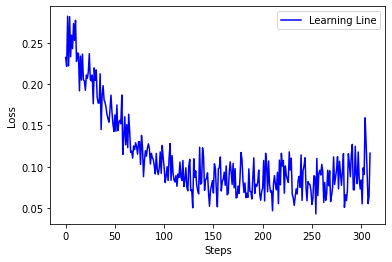




0it [00:00, ?it/s]


Train Epoch: 1 [0/6200 (0%)]	Loss: 0.058313: : 0it [00:00, ?it/s]


Train Epoch: 1 [0/6200 (0%)]	Loss: 0.058313: : 1it [00:00,  1.73it/s]


Train Epoch: 1 [20/6200 (0%)]	Loss: 0.083714: : 1it [00:01,  1.73it/s]


Train Epoch: 1 [20/6200 (0%)]	Loss: 0.083714: : 2it [00:01,  1.74it/s]


Train Epoch: 1 [40/6200 (1%)]	Loss: 0.073715: : 2it [00:01,  1.74it/s]


Train Epoch: 1 [40/6200 (1%)]	Loss: 0.073715: : 3it [00:01,  1.64it/s]


Train Epoch: 1 [60/6200 (1%)]	Loss: 0.102594: : 3it [00:02,  1.64it/s]


Train Epoch: 1 [60/6200 (1%)]	Loss: 0.102594: : 4it [00:02,  1.64it/s]


Train Epoch: 1 [80/6200 (1%)]	Loss: 0.057698: : 4it [00:03,  1.64it/s]


Train Epoch: 1 [80/6200 (1%)]	Loss: 0.057698: : 5it [00:03,  1.68it/s]


Train Epoch: 1 [100/6200 (2%)]	Loss: 0.075258: : 5it [00:03,  1.68it/s]


Train Epoch: 1 [100/6200 (2%)]	Loss: 0.075258: : 6it [00:03,  1.70it/s]


Train Epoch: 1 [120/6200 (2%)]	Loss: 0.128984: : 6it [00:04,  1.70it/s]


Train Epoch: 1 [120/6200 (2%)]

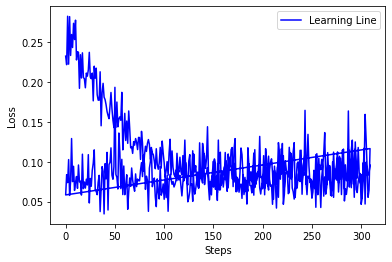




0it [00:00, ?it/s]


Train Epoch: 2 [0/6200 (0%)]	Loss: 0.113474: : 0it [00:00, ?it/s]


Train Epoch: 2 [0/6200 (0%)]	Loss: 0.113474: : 1it [00:00,  1.68it/s]


Train Epoch: 2 [20/6200 (0%)]	Loss: 0.061708: : 1it [00:01,  1.68it/s]


Train Epoch: 2 [20/6200 (0%)]	Loss: 0.061708: : 2it [00:01,  1.72it/s]


Train Epoch: 2 [40/6200 (1%)]	Loss: 0.090048: : 2it [00:01,  1.72it/s]


Train Epoch: 2 [40/6200 (1%)]	Loss: 0.090048: : 3it [00:01,  1.67it/s]


Train Epoch: 2 [60/6200 (1%)]	Loss: 0.059818: : 3it [00:02,  1.67it/s]


Train Epoch: 2 [60/6200 (1%)]	Loss: 0.059818: : 4it [00:02,  1.71it/s]


Train Epoch: 2 [80/6200 (1%)]	Loss: 0.091139: : 4it [00:02,  1.71it/s]


Train Epoch: 2 [80/6200 (1%)]	Loss: 0.091139: : 5it [00:02,  1.73it/s]


Train Epoch: 2 [100/6200 (2%)]	Loss: 0.096414: : 5it [00:03,  1.73it/s]


Train Epoch: 2 [100/6200 (2%)]	Loss: 0.096414: : 6it [00:03,  1.76it/s]


Train Epoch: 2 [120/6200 (2%)]	Loss: 0.092629: : 6it [00:04,  1.76it/s]


Train Epoch: 2 [120/6200 (2%)]

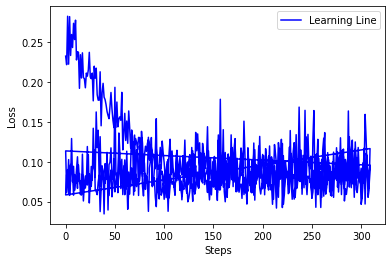




0it [00:00, ?it/s]


Train Epoch: 3 [0/6200 (0%)]	Loss: 0.071230: : 0it [00:00, ?it/s]


Train Epoch: 3 [0/6200 (0%)]	Loss: 0.071230: : 1it [00:00,  1.54it/s]


Train Epoch: 3 [20/6200 (0%)]	Loss: 0.074341: : 1it [00:01,  1.54it/s]


Train Epoch: 3 [20/6200 (0%)]	Loss: 0.074341: : 2it [00:01,  1.60it/s]


Train Epoch: 3 [40/6200 (1%)]	Loss: 0.092555: : 2it [00:01,  1.60it/s]


Train Epoch: 3 [40/6200 (1%)]	Loss: 0.092555: : 3it [00:01,  1.62it/s]


Train Epoch: 3 [60/6200 (1%)]	Loss: 0.079106: : 3it [00:02,  1.62it/s]


Train Epoch: 3 [60/6200 (1%)]	Loss: 0.079106: : 4it [00:02,  1.65it/s]


Train Epoch: 3 [80/6200 (1%)]	Loss: 0.066153: : 4it [00:02,  1.65it/s]


Train Epoch: 3 [80/6200 (1%)]	Loss: 0.066153: : 5it [00:02,  1.69it/s]


Train Epoch: 3 [100/6200 (2%)]	Loss: 0.107332: : 5it [00:03,  1.69it/s]


Train Epoch: 3 [100/6200 (2%)]	Loss: 0.107332: : 6it [00:03,  1.69it/s]


Train Epoch: 3 [120/6200 (2%)]	Loss: 0.062518: : 6it [00:04,  1.69it/s]


Train Epoch: 3 [120/6200 (2%)]

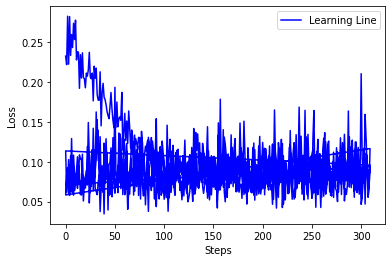




0it [00:00, ?it/s]


Train Epoch: 4 [0/6200 (0%)]	Loss: 0.100087: : 0it [00:00, ?it/s]


Train Epoch: 4 [0/6200 (0%)]	Loss: 0.100087: : 1it [00:00,  1.78it/s]


Train Epoch: 4 [20/6200 (0%)]	Loss: 0.121610: : 1it [00:01,  1.78it/s]


Train Epoch: 4 [20/6200 (0%)]	Loss: 0.121610: : 2it [00:01,  1.77it/s]


Train Epoch: 4 [40/6200 (1%)]	Loss: 0.090817: : 2it [00:01,  1.77it/s]


Train Epoch: 4 [40/6200 (1%)]	Loss: 0.090817: : 3it [00:01,  1.73it/s]


Train Epoch: 4 [60/6200 (1%)]	Loss: 0.111857: : 3it [00:02,  1.73it/s]


Train Epoch: 4 [60/6200 (1%)]	Loss: 0.111857: : 4it [00:02,  1.73it/s]


Train Epoch: 4 [80/6200 (1%)]	Loss: 0.073535: : 4it [00:02,  1.73it/s]


Train Epoch: 4 [80/6200 (1%)]	Loss: 0.073535: : 5it [00:02,  1.74it/s]


Train Epoch: 4 [100/6200 (2%)]	Loss: 0.087506: : 5it [00:03,  1.74it/s]


Train Epoch: 4 [100/6200 (2%)]	Loss: 0.087506: : 6it [00:03,  1.75it/s]


Train Epoch: 4 [120/6200 (2%)]	Loss: 0.069278: : 6it [00:04,  1.75it/s]


Train Epoch: 4 [120/6200 (2%)]

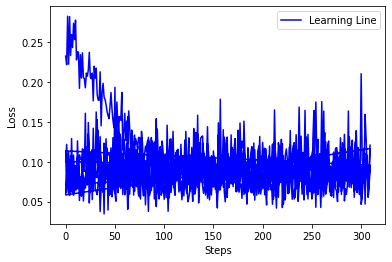




0it [00:00, ?it/s]


Train Epoch: 5 [0/6200 (0%)]	Loss: 0.100566: : 0it [00:00, ?it/s]


Train Epoch: 5 [0/6200 (0%)]	Loss: 0.100566: : 1it [00:00,  1.71it/s]


Train Epoch: 5 [20/6200 (0%)]	Loss: 0.152362: : 1it [00:01,  1.71it/s]


Train Epoch: 5 [20/6200 (0%)]	Loss: 0.152362: : 2it [00:01,  1.69it/s]


Train Epoch: 5 [40/6200 (1%)]	Loss: 0.100598: : 2it [00:01,  1.69it/s]


Train Epoch: 5 [40/6200 (1%)]	Loss: 0.100598: : 3it [00:01,  1.68it/s]


Train Epoch: 5 [60/6200 (1%)]	Loss: 0.104671: : 3it [00:02,  1.68it/s]


Train Epoch: 5 [60/6200 (1%)]	Loss: 0.104671: : 4it [00:02,  1.72it/s]


Train Epoch: 5 [80/6200 (1%)]	Loss: 0.168048: : 4it [00:03,  1.72it/s]


Train Epoch: 5 [80/6200 (1%)]	Loss: 0.168048: : 5it [00:03,  1.60it/s]


Train Epoch: 5 [100/6200 (2%)]	Loss: 0.107614: : 5it [00:03,  1.60it/s]


Train Epoch: 5 [100/6200 (2%)]	Loss: 0.107614: : 6it [00:03,  1.62it/s]


Train Epoch: 5 [120/6200 (2%)]	Loss: 0.096648: : 6it [00:04,  1.62it/s]


Train Epoch: 5 [120/6200 (2%)]

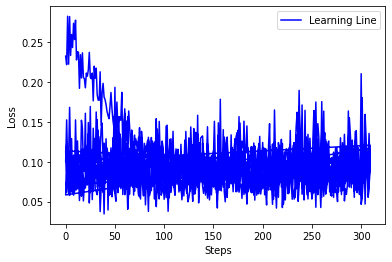




0it [00:00, ?it/s]


Train Epoch: 6 [0/6200 (0%)]	Loss: 0.148469: : 0it [00:00, ?it/s]


Train Epoch: 6 [0/6200 (0%)]	Loss: 0.148469: : 1it [00:00,  1.23it/s]


Train Epoch: 6 [20/6200 (0%)]	Loss: 0.131460: : 1it [00:01,  1.23it/s]


Train Epoch: 6 [20/6200 (0%)]	Loss: 0.131460: : 2it [00:01,  1.33it/s]


Train Epoch: 6 [40/6200 (1%)]	Loss: 0.091471: : 2it [00:02,  1.33it/s]


Train Epoch: 6 [40/6200 (1%)]	Loss: 0.091471: : 3it [00:02,  1.37it/s]


Train Epoch: 6 [60/6200 (1%)]	Loss: 0.072356: : 3it [00:02,  1.37it/s]


Train Epoch: 6 [60/6200 (1%)]	Loss: 0.072356: : 4it [00:02,  1.47it/s]


Train Epoch: 6 [80/6200 (1%)]	Loss: 0.148926: : 4it [00:03,  1.47it/s]


Train Epoch: 6 [80/6200 (1%)]	Loss: 0.148926: : 5it [00:03,  1.52it/s]


Train Epoch: 6 [100/6200 (2%)]	Loss: 0.161096: : 5it [00:03,  1.52it/s]


Train Epoch: 6 [100/6200 (2%)]	Loss: 0.161096: : 6it [00:03,  1.59it/s]


Train Epoch: 6 [120/6200 (2%)]	Loss: 0.094075: : 6it [00:04,  1.59it/s]


Train Epoch: 6 [120/6200 (2%)]

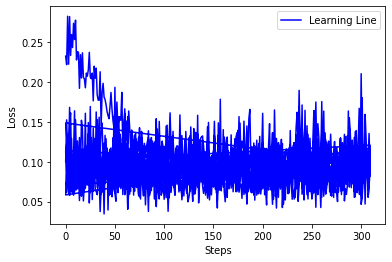




0it [00:00, ?it/s]


Train Epoch: 7 [0/6200 (0%)]	Loss: 0.089479: : 0it [00:00, ?it/s]


Train Epoch: 7 [0/6200 (0%)]	Loss: 0.089479: : 1it [00:00,  1.74it/s]


Train Epoch: 7 [20/6200 (0%)]	Loss: 0.103757: : 1it [00:01,  1.74it/s]


Train Epoch: 7 [20/6200 (0%)]	Loss: 0.103757: : 2it [00:01,  1.75it/s]


Train Epoch: 7 [40/6200 (1%)]	Loss: 0.112233: : 2it [00:01,  1.75it/s]


Train Epoch: 7 [40/6200 (1%)]	Loss: 0.112233: : 3it [00:01,  1.74it/s]


Train Epoch: 7 [60/6200 (1%)]	Loss: 0.131100: : 3it [00:02,  1.74it/s]


Train Epoch: 7 [60/6200 (1%)]	Loss: 0.131100: : 4it [00:02,  1.75it/s]


Train Epoch: 7 [80/6200 (1%)]	Loss: 0.103699: : 4it [00:02,  1.75it/s]


Train Epoch: 7 [80/6200 (1%)]	Loss: 0.103699: : 5it [00:02,  1.76it/s]


Train Epoch: 7 [100/6200 (2%)]	Loss: 0.094201: : 5it [00:03,  1.76it/s]


Train Epoch: 7 [100/6200 (2%)]	Loss: 0.094201: : 6it [00:03,  1.78it/s]


Train Epoch: 7 [120/6200 (2%)]	Loss: 0.101609: : 6it [00:03,  1.78it/s]


Train Epoch: 7 [120/6200 (2%)]

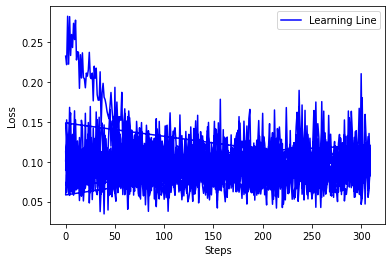




0it [00:00, ?it/s]


Train Epoch: 8 [0/6200 (0%)]	Loss: 0.101232: : 0it [00:00, ?it/s]


Train Epoch: 8 [0/6200 (0%)]	Loss: 0.101232: : 1it [00:00,  1.24it/s]


Train Epoch: 8 [20/6200 (0%)]	Loss: 0.083709: : 1it [00:01,  1.24it/s]


Train Epoch: 8 [20/6200 (0%)]	Loss: 0.083709: : 2it [00:01,  1.37it/s]


Train Epoch: 8 [40/6200 (1%)]	Loss: 0.097128: : 2it [00:01,  1.37it/s]


Train Epoch: 8 [40/6200 (1%)]	Loss: 0.097128: : 3it [00:01,  1.44it/s]


Train Epoch: 8 [60/6200 (1%)]	Loss: 0.088907: : 3it [00:02,  1.44it/s]


Train Epoch: 8 [60/6200 (1%)]	Loss: 0.088907: : 4it [00:02,  1.53it/s]


Train Epoch: 8 [80/6200 (1%)]	Loss: 0.078832: : 4it [00:03,  1.53it/s]


Train Epoch: 8 [80/6200 (1%)]	Loss: 0.078832: : 5it [00:03,  1.61it/s]


Train Epoch: 8 [100/6200 (2%)]	Loss: 0.104648: : 5it [00:03,  1.61it/s]


Train Epoch: 8 [100/6200 (2%)]	Loss: 0.104648: : 6it [00:03,  1.61it/s]


Train Epoch: 8 [120/6200 (2%)]	Loss: 0.100322: : 6it [00:04,  1.61it/s]


Train Epoch: 8 [120/6200 (2%)]

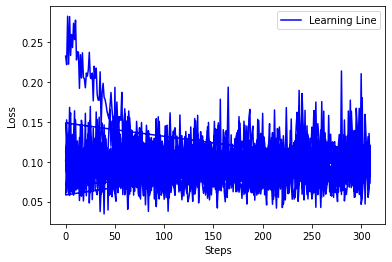




0it [00:00, ?it/s]


Train Epoch: 9 [0/6200 (0%)]	Loss: 0.100967: : 0it [00:00, ?it/s]


Train Epoch: 9 [0/6200 (0%)]	Loss: 0.100967: : 1it [00:00,  1.75it/s]


Train Epoch: 9 [20/6200 (0%)]	Loss: 0.131786: : 1it [00:01,  1.75it/s]


Train Epoch: 9 [20/6200 (0%)]	Loss: 0.131786: : 2it [00:01,  1.76it/s]


Train Epoch: 9 [40/6200 (1%)]	Loss: 0.107287: : 2it [00:01,  1.76it/s]


Train Epoch: 9 [40/6200 (1%)]	Loss: 0.107287: : 3it [00:01,  1.77it/s]


Train Epoch: 9 [60/6200 (1%)]	Loss: 0.084607: : 3it [00:02,  1.77it/s]


Train Epoch: 9 [60/6200 (1%)]	Loss: 0.084607: : 4it [00:02,  1.78it/s]


Train Epoch: 9 [80/6200 (1%)]	Loss: 0.114073: : 4it [00:02,  1.78it/s]


Train Epoch: 9 [80/6200 (1%)]	Loss: 0.114073: : 5it [00:02,  1.74it/s]


Train Epoch: 9 [100/6200 (2%)]	Loss: 0.119530: : 5it [00:03,  1.74it/s]


Train Epoch: 9 [100/6200 (2%)]	Loss: 0.119530: : 6it [00:03,  1.71it/s]


Train Epoch: 9 [120/6200 (2%)]	Loss: 0.113873: : 6it [00:04,  1.71it/s]


Train Epoch: 9 [120/6200 (2%)]

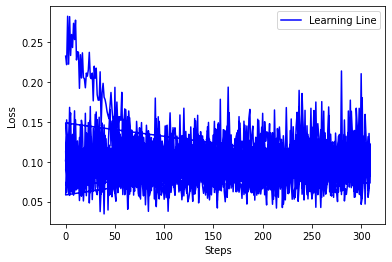

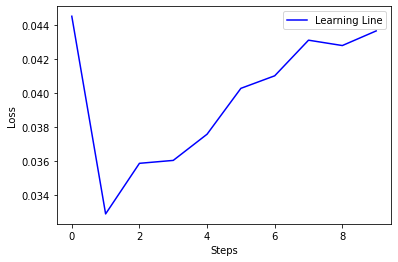

Finished Training


In [67]:
#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
T1_VGG16_Model.to(device)

T1_VGG16_Model.train()

T1_VGG16_1EpochLossLst = list()
T1_VGG16_1EpochLst = list()
T1_VGG16_EpochLst = list()
T1_VGG16_EpochLossLst = list()

T1_VGG16_EpochEncLabel = list()
T1_VGG16_EpochEncPred = list()
T1_VGG16_TotalAccuracyList = list()

for epoch in range(T1_Vgg16_Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        T1_Vgg16_Optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = T1_VGG16_Model(inputs)                      #----> forward pass

        encOutput = hotEncodingPrediction(outputs)
        encSigmoidOutput = hotEncodingPrediction(torch.sigmoid(outputs))
        encLabel = oneHotEncodingLabel(labels)  
        loss = T1_Vgg16_Criterion(encOutput, encLabel)               #----> compute loss
        #BCE_loss = T1_ResNet18_Criterion(outputs, outLabel)

        pt = torch.exp(-loss)
        loss = T1_Vgg16_BCE_alpha * (1-pt)**T1_Vgg16_BCE_gamma * loss


        loss.backward()                                       #----> backward pass
        T1_Vgg16_Optimizer.step()                             #----> weights update

        # print statistics
        running_loss += loss.item() * images.size(0) 
        
        pbar.set_description('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset), 100. * i / len(trainloader), loss.item()))
        
        T1_VGG16_1EpochLst.append(loss.item())
        T1_VGG16_1EpochLossLst.append(i)
        
    plot_curve(T1_VGG16_1EpochLossLst,T1_VGG16_1EpochLst)
    T1_VGG16_EpochLst.append(epoch)
    T1_VGG16_EpochLossLst.append(running_loss/len(trainloader.dataset))

    torch.save(T1_VGG16_Model.state_dict(), 'vgg16_focal_loss.pth')

plot_curve(T1_VGG16_EpochLst,T1_VGG16_EpochLossLst)
print('Finished Training')

In [0]:
len(trainloader)

310

Testing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


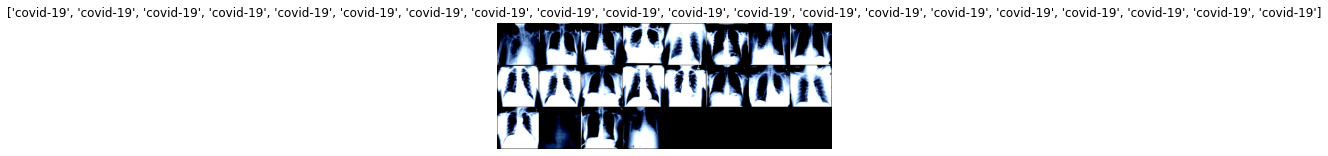

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()
show_databatch(images, labels)

Prediction

In [0]:
# images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
# outputs = T1_VGG16_Model(images)                               #--> forward pass
# _, predicted = torch.max(outputs, 1)

# print('Predicted: ', ' '.join('%10s' % class_names[predicted[j]]
#                               for j in range(len(images))))
# print('Ground Truth: ', ' '.join('%10s' % class_names[labels[j]]
#                               for j in range(len(images)))) 

In [68]:
i = 0
with open('COVIDTestPredictionVGG.csv', 'w', newline='') as file:
  writer = csv.writer(file)
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          outputs = T1_VGG16_Model(images)
          _, predicted = torch.max(outputs.data, 1)
        
          for itr in range(20):
            if (i == len(testloader.dataset.samples)):
              break
            fname, _ = testloader.dataset.samples[i]  
            i = i + 1
            
            if(predicted[itr] == 0):
              writer.writerow([fname, 1, 0, 0])
            if(predicted[itr] == 1):
              writer.writerow([fname, 0, 1, 0])
            if(predicted[itr] == 2):
              writer.writerow([fname, 0, 0, 1])
              
print('Predicted and File Generated COVIDTestPredictionVGG.csv')

Predicted and File Generated COVIDTestPredictionVGG.csv


On Training Data

In [69]:
correct = 0
total = 0
all_out_pred_list = list()
all_out_label_list = list()

with torch.no_grad():
    for data in trainloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = T1_VGG16_Model(images)
        _, predicted = torch.max(outputs.data, 1)
        # preparing list to find accuracy
        all_out_pred_list.extend(hotEncodingPrediction(torch.sigmoid(outputs.data)).cpu().numpy())
        all_out_label_list.extend(oneHotEncodingLabel(labels).cpu().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
     

print('*Training* T1_VGG16_Model [Precision, Recall, F1, Accuracy]')
print('\nAccuracy of the network on the '+ str(len(train_data)) +' train images: %d %%' % (
    100 * correct / total))
print("Confusion Matrix:")
print(multilabel_confusion_matrix(all_out_label_list, all_out_pred_list))    
print("Classification Report:")
print(classification_report(all_out_label_list, all_out_pred_list)) 

*Training* T1_VGG16_Model [Precision, Recall, F1, Accuracy]

Accuracy of the network on the 6200 train images: 84 %
Confusion Matrix:
[[[6000    0]
  [ 200    0]]

 [[ 566 1508]
  [3785  341]]

 [[ 348 3792]
  [1501  559]]]
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       200
           1       0.18      0.08      0.11      4126
           2       0.13      0.27      0.17      2060

   micro avg       0.15      0.14      0.14      6386
   macro avg       0.10      0.12      0.10      6386
weighted avg       0.16      0.14      0.13      6386
 samples avg       0.15      0.14      0.14      6386



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


On Vlidation

In [70]:
correct = 0
total = 0
all_out_pred_list = list()
all_out_label_list = list()

with torch.no_grad():
    for data in validloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = T1_VGG16_Model(images)
        _, predicted = torch.max(outputs.data, 1)
        # preparing list to find accuracy
        all_out_pred_list.extend(hotEncodingPrediction(torch.sigmoid(outputs.data)).cpu().numpy())
        all_out_label_list.extend(oneHotEncodingLabel(labels).cpu().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
  

print('*Validation* T1_VGG16_Model [Precision, Recall, F1, Accuracy]')
print('\nAccuracy of the network on the '+ str(len(valid_data)) +' validation images: %d %%' % (
    100 * correct / total))
print("Confusion Matrix:")
print(multilabel_confusion_matrix(all_out_label_list, all_out_pred_list))    
print("Classification Report:")
print(classification_report(all_out_label_list, all_out_pred_list)) 

*Validation* T1_VGG16_Model [Precision, Recall, F1, Accuracy]

Accuracy of the network on the 628 validation images: 85 %
Confusion Matrix:
[[[600   0]
  [ 28   0]]

 [[ 41 170]
  [380  37]]

 [[ 38 380]
  [169  41]]]
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.18      0.09      0.12       417
           2       0.10      0.20      0.13       210

   micro avg       0.12      0.12      0.12       655
   macro avg       0.09      0.09      0.08       655
weighted avg       0.15      0.12      0.12       655
 samples avg       0.12      0.11      0.12       655



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


tensor([[  1.,  18.,   9.],
        [  0., 395.,   5.],
        [  0.,  34., 166.]])


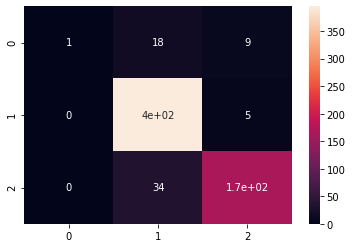

In [0]:
# Confusion Matrix of VALID 

confusion_matrix = torch.zeros(3, 3)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(validloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = T1_VGG16_Model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
              
print(confusion_matrix)
sn.heatmap(confusion_matrix, annot=True)